In [1]:
import ase
import ase.io
import numpy as np
import sys
import matplotlib.pyplot as plt
import abtem
# %matplotlib ipympl

sys.path.append('../..')
lufeo3 = ase.io.read("../../data/structures/LFO_orth.cif")

## STEM Walkthrough

In [2]:
abtem.config.set({"device": "cpu", "fft": "fftw"})

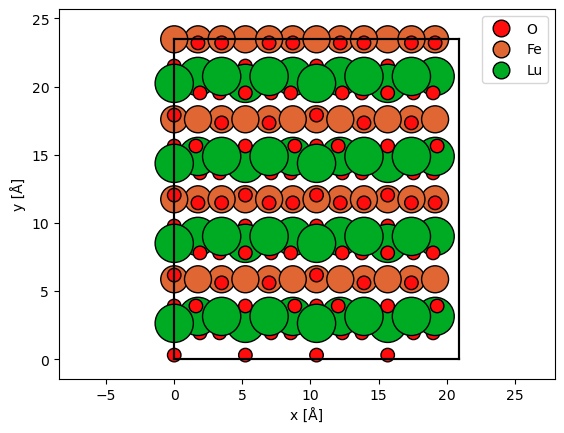

In [16]:
cif_path = '../../data/structures/LFO_Orth.cif'
atoms = ase.io.read(cif_path)
atoms *= (2, 2, 1)
abtem.show_atoms(atoms, plane="xy", legend=True, numbering=False, merge=False);


In [17]:
potential = abtem.Potential(atoms, sampling=0.05, plane='xy')

In [ ]:
probe = abtem.Probe(energy=100e3, semiangle_cutoff=None, Cs=5.6e4, defocus=0) #Cs in Å
probe.grid.match(potential)

print(f"defocus = {probe.aberrations.defocus} Å")
print(f"FWHM = {probe.profiles().width().compute()} Å")

defocus = 0 Å
FWHM = 0.6979652047157288 Å


[########################################] | 100% Completed | 103.58 ms
[########################################] | 100% Completed | 102.71 ms


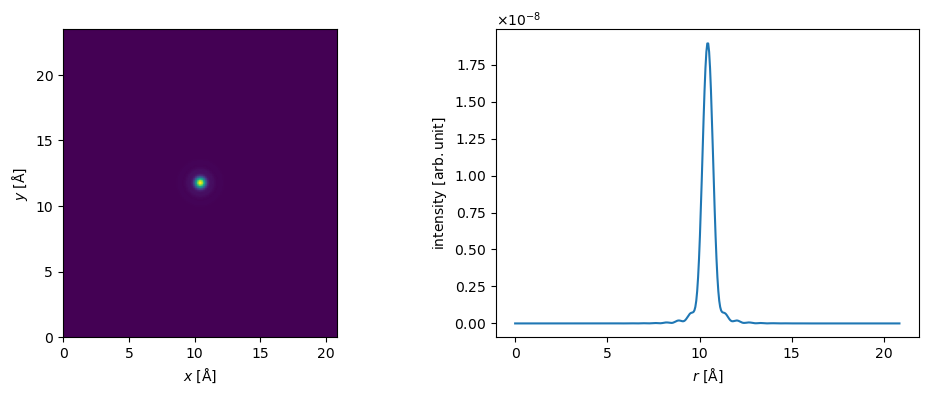

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);

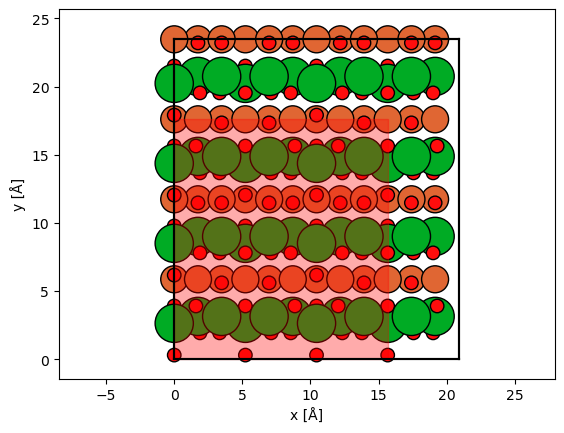

In [33]:
grid_scan = abtem.GridScan(
    start=(0, 0),
    end=(3/4, 3/4),
    sampling=probe.aperture.nyquist_sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(atoms, plane="xy")
grid_scan.add_to_plot(ax)

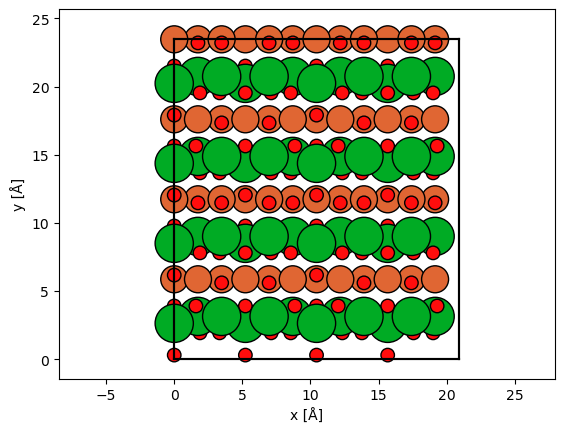

In [34]:
fig, ax = abtem.show_atoms(atoms, plane="xy")

In [35]:
detector = abtem.FlexibleAnnularDetector()

In [36]:
flexible_measurement = probe.scan(potential, scan=grid_scan, detectors=detector)

flexible_measurement.compute()

[########################################] | 100% Completed | 20.94 s


In [37]:
bf_measurement = flexible_measurement.integrate_radial(0, probe.semiangle_cutoff)
maadf_measurement = flexible_measurement.integrate_radial(50, 150)
haadf_measurement = flexible_measurement.integrate_radial(90, 200)

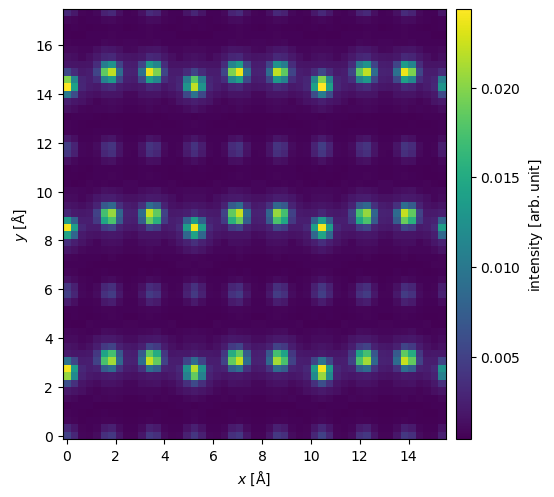

In [38]:
haadf_measurement.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

In [39]:
interpolated_measurements = haadf_measurement.interpolate(0.05)
filtered_measurements = interpolated_measurements.gaussian_filter(0.3)

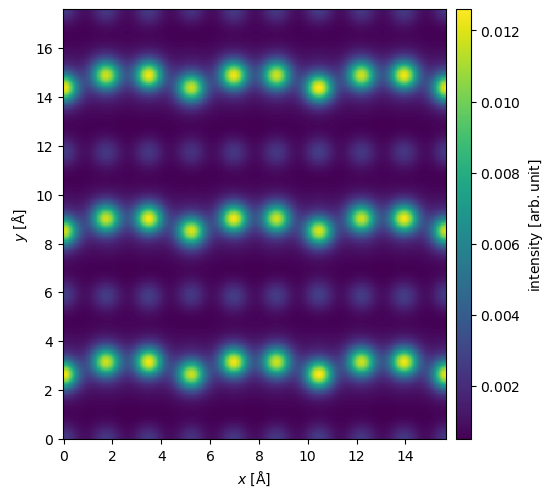

In [40]:
filtered_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

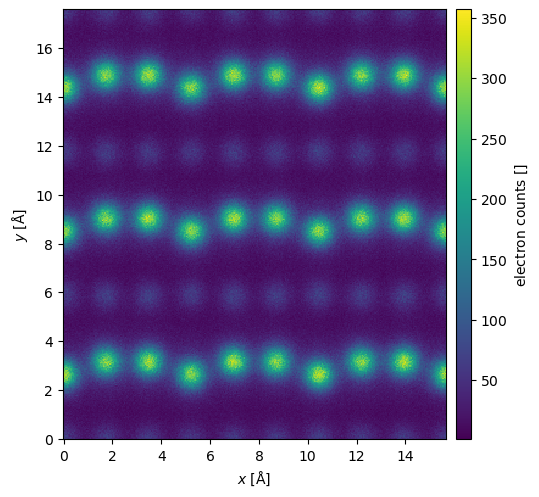

In [41]:
noisy_measurements = filtered_measurements.poisson_noise(dose_per_area=1e7)

noisy_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

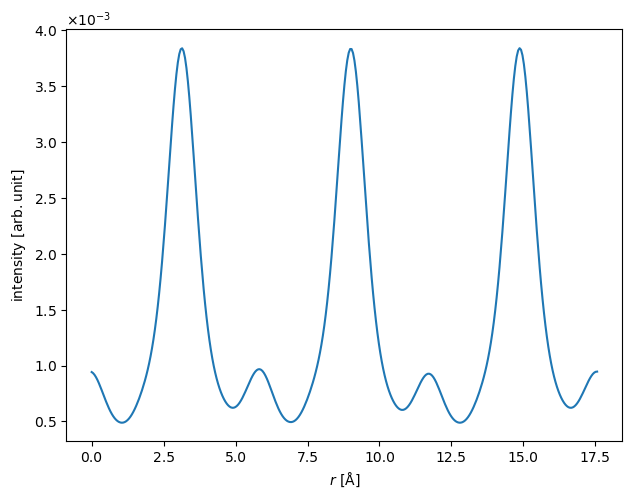

In [42]:
line_profile = filtered_measurements.interpolate_line(
    start=(1 / 2, 0), end=(1 / 2, 1), fractional=True
)

line_profile.show();

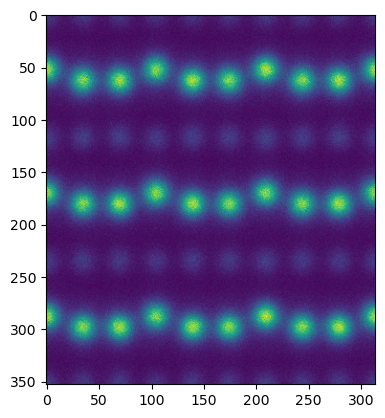

In [43]:
plt.imshow(noisy_measurements.array.T)